# Fingerprinting Analysis

In [0]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Import JavaScript Crawl Data

In [0]:
import pandas as pd

#load javascript data
javascript_df = pd.read_csv("/content/drive/My Drive/IT_Security/Code and Data/javascript.csv")

print(len(javascript_df))

2066691


In [0]:
javascript_df.head()
javascript_df.info()
type(javascript_df.symbol[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2066691 entries, 0 to 2066690
Data columns (total 8 columns):
script_url       object
symbol           object
operation        object
value            object
top_level_url    object
func_name        object
arguments        object
visit_id         int64
dtypes: int64(1), object(7)
memory usage: 126.1+ MB


str

In [0]:
#total number of distinct scripts
len(list(set(javascript_df.script_url)))

48664

## Extract Calls that use Canvas related interfaces

In [0]:
#filter canvas symbol elements
js_canvas_df = javascript_df[javascript_df.symbol.str.contains('Canvas')]

#HTMLCanvasElement
#CanvasRenderingContext2D

print(len(js_canvas_df),"\n")
print(js_canvas_df.head(), "\n")

js_canvas_df.symbol.value_counts()

330045 

                                             script_url  ... visit_id
6     https://www.dhl.de/etc.clientlibs/redesign/cli...  ...        3
7     https://www.dhl.de/etc.clientlibs/redesign/cli...  ...        3
2979  https://tags.tiqcdn.com/utag/vodafone/de-main/...  ...       11
2980  https://tags.tiqcdn.com/utag/vodafone/de-main/...  ...       11
5318    https://www.daserste.de/mediasrc/js/brav-min.js  ...       17

[5 rows x 8 columns] 



CanvasRenderingContext2D.fillStyle       44748
CanvasRenderingContext2D.fill            43019
CanvasRenderingContext2D.save            42706
CanvasRenderingContext2D.restore         42687
HTMLCanvasElement.width                  16488
                                         ...  
HTMLCanvasElement.removeEventListener        3
HTMLCanvasElement.hasChildNodes              2
HTMLCanvasElement.getRootNode                2
CanvasRenderingContext2D.ellipse             1
HTMLCanvasElement.offsetParent               1
Name: symbol, Length: 100, dtype: int64

## Determine Idividual Scripts that utilize HTML Canvas Functionality

In [0]:
#extracting set of individual script urls
script_url_set = list(set(js_canvas_df.script_url))

#prepare dataframe with individual script urls
script_url_df = pd.DataFrame(script_url_set, columns=['script_url'])
script_url_df.script_url = script_url_df.script_url.apply(lambda x: str(x))

script_url_df['01_picture_rendering'] = 0
script_url_df['02_text_rendering_color'] = 0
script_url_df['02_text_rendering_length'] = 0
script_url_df['03_no_excluded_calls'] = 0
script_url_df['04_toDataURL_included'] = 0
script_url_df['04_getImageData_included'] = 0

script_url_df[:5]

,script_url,01_picture_rendering,02_text_rendering_color,02_text_rendering_length,03_no_excluded_calls,04_toDataURL_included,04_getImageData_included
0,nan,0,0,0,0,0,0
1,https://www.wiwiweb.de/assets/js/wiwiweb_de-fu...,0,0,0,0,0,0
2,https://www.stromio.de/js/modernizr_2.8.3.min.js,0,0,0,0,0,0
3,https://www.rv-direkt.de/TSPD/086307da23ab2000...,0,0,0,0,0,0
4,https://cdn.asn.advolution.de/cr/00076d87/KYO_...,0,0,0,0,0,0


## Analysis of Canvas Fingerprinting

### Check all Criteria for each individual Script

#### (1) Picture Rendering

In [0]:
#(1) PICTURE RENDERING
import re

#define function to identify values that cannot be converted to float
def toFloat(x):
    try:
        float(x)
    except:
        l.append(x)
    pass

#example for script with width and height above 16 px
#example_script = 'https://cdn-de.f11-ads.com/banner/f11de/33340/2019-12-02/2_sitebar_marcapo_baer_7955_zip/Sitebar_Marcapo_Baer_7955/webb_800x1200_sitebar_f11_kr_offensive_2019.js'

js_canvas_df.script_url = js_canvas_df.script_url.apply(lambda x: str(x))

for script_url in script_url_df.script_url:

    #filter canvas javascript calls according to current script url
    filtered_canvas_df = js_canvas_df[js_canvas_df.script_url == script_url]

    #check for presence of width and height symbols
    if (filtered_canvas_df['symbol'].str.contains('HTMLCanvasElement.width').any()) and (filtered_canvas_df['symbol'].str.contains('HTMLCanvasElement.height').any()):
        symbol_found = True
    else:
        symbol_found = False

    #if no symbol was found
    if not(symbol_found):
        script_url_df['01_picture_rendering'][script_url_df.script_url == script_url] = False
        continue

    #if symbol was found
    if symbol_found:
        #filter canvas width and height symbols
        js_canvas_width_height_df = filtered_canvas_df[filtered_canvas_df.symbol.isin(['HTMLCanvasElement.width', 'HTMLCanvasElement.height'])]

        #convert size values to float
        #prepare list
        l = list()
        
        #apply function to identify not convertable values
        js_canvas_width_height_df.value.apply(lambda x: toFloat(x))

        #remove rows that cannot be converted to float
        js_canvas_width_height_df = js_canvas_width_height_df[~js_canvas_width_height_df.value.isin(l)]

        #convert values to float
        js_canvas_width_height_df.value = js_canvas_width_height_df.value.apply(lambda x: float(x))

        #check whether width and height elements are still included
        if (js_canvas_width_height_df['symbol'].str.contains('HTMLCanvasElement.width').any()) and (js_canvas_width_height_df['symbol'].str.contains('HTMLCanvasElement.height').any()):
            symbol_found = True
        else:
            symbol_found = False

        if not(symbol_found):
            script_url_df['01_picture_rendering'][script_url_df.script_url == script_url] = False
            continue
        else:
            #separate width and height values
            js_canvas_width_df = js_canvas_width_height_df[js_canvas_width_height_df.symbol.isin(['HTMLCanvasElement.width'])]
            js_canvas_height_df = js_canvas_width_height_df[js_canvas_width_height_df.symbol.isin(['HTMLCanvasElement.height'])]

            #check for presence of value larger 16
            width_value = 0
            height_value = 0

            #for width
            js_canvas_width_df = js_canvas_width_df[js_canvas_width_df.value >= 16]
            if len(js_canvas_width_df) > 0:
                width_value = 1
            else:
                width_value = 0

            #for height
            js_canvas_height_df = js_canvas_height_df[js_canvas_height_df.value >= 16]
            if len(js_canvas_height_df) > 0:
                height_value = 1
            else:
                height_value = 0

            #return final result
            if (width_value == 1) and (height_value == 1):
                script_url_df['01_picture_rendering'][script_url_df.script_url == script_url] = True
            else:
                script_url_df['01_picture_rendering'][script_url_df.script_url == script_url] = False

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-pack

In [0]:
script_url_df[:10]

,script_url,01_picture_rendering,02_text_rendering_color,02_text_rendering_length,03_no_excluded_calls,04_toDataURL_included,04_getImageData_included
0,nan,False,0,0,0,0,0
1,https://www.schuhe.de/assets/js/modernizr-2.8....,False,0,0,0,0,0
2,http://imagesrv.adition.com/banners/268/00/a1/...,True,0,0,0,0,0
3,https://www.fair-news.de/press/wp-content/cach...,False,0,0,0,0,0
4,https://www.continentale.de/conti-theme/js/com...,False,0,0,0,0,0
5,https://www.sozialhilfe24.de/wp-content/cache/...,False,0,0,0,0,0
6,https://www.lindtchocoladenclub.de/static/base...,False,0,0,0,0,0
7,https://cdn.flashtalking.com/115441/2879004/in...,False,0,0,0,0,0
8,https://s0.2mdn.net/ads/studio/Enabler.js,False,0,0,0,0,0
9,https://www.frank-dietrich-fachmakler.de/wp-in...,False,0,0,0,0,0


#### (2) Text Rendering

In [0]:
#TEXT RENDERING - COLOR

#script_url = 'https://analytics.velomotion.de/analytics.js?id=VM-666NICK1A413'

for script_url in script_url_df.script_url:

    #filter canvas javascript calls according to current script url
    filtered_canvas_df = js_canvas_df[js_canvas_df.script_url == script_url]

    #1 checking whether text was drawn with at least 2 colors
    #check for presence of fillStyle symbols
    if filtered_canvas_df['symbol'].str.contains('CanvasRenderingContext2D.fillStyle').any():
        symbol_found = True
    else:
        symbol_found = False

    #if no symbol was found
    if not(symbol_found):
        script_url_df['02_text_rendering_color'][script_url_df.script_url == script_url] = False
        continue

    #if symbol was found
    if symbol_found:
        #filter canvas fillStyle symbols
        js_canvas_fillStyle_df = filtered_canvas_df[filtered_canvas_df.symbol.isin(['CanvasRenderingContext2D.fillStyle'])]

        #check whether two distict colors were used
        colors = list(js_canvas_fillStyle_df.value)

        #count number of distinct colors
        color_count = len(list(set(colors)))

        if color_count > 1:
            script_url_df['02_text_rendering_color'][script_url_df.script_url == script_url] = True
        else:
            script_url_df['02_text_rendering_color'][script_url_df.script_url == script_url] = False

In [0]:
script_url_df[20:30]

,script_url,01_picture_rendering,02_text_rendering_color,02_text_rendering_length,03_no_excluded_calls,04_toDataURL_included,04_getImageData_included
20,https://www.kunststoffweb.de/_assets/js/_app.m...,False,False,0,0,0,0
21,https://www.gesetze-bayern.de/bundles/moderniz...,False,False,0,0,0,0
22,https://www.bigtrax.de/wp-content/cache/autopt...,True,True,0,0,0,0
23,https://www.netz98.de/wp-content/themes/fekra/...,False,False,0,0,0,0
24,https://www.presseplus.de/bundles/layoutjs?v=s...,False,False,0,0,0,0
25,https://cdn-de.f11-ads.com/banner/f11de/29209/...,True,False,0,0,0,0
26,https://s.bega.com/fp-40516465/media/resources...,False,False,0,0,0,0
27,https://filehorst.de/res/scripts/plupload/js/p...,False,False,0,0,0,0
28,https://www.testspiel.de/,True,False,0,0,0,0
29,https://www.stilinberlin.de/,True,False,0,0,0,0


In [0]:
#TEXT RENDERING - LENGTH

#function to prepare text from database
def textPrep(x):
    x = x.split('"')
    x.pop(0)

    try:
        x.pop((len(x)) - 1)
    except:
        pass

    return str('"'.join(x))


#script_url = 'https://analytics.velomotion.de/analytics.js?id=VM-666NICK1A413'

for script_url in script_url_df.script_url:

    #filter canvas javascript calls according to current script url
    filtered_canvas_df = js_canvas_df[js_canvas_df.script_url == script_url]

    #2 check text length
    #check for presence of width and height symbols
    if filtered_canvas_df['symbol'].str.contains('CanvasRenderingContext2D.fillText').any():
        symbol_found = True
    else:
        symbol_found = False

    #if no symbol was found
    if not(symbol_found):
        script_url_df['02_text_rendering_length'][script_url_df.script_url == script_url] = False
        continue

    #if symbol was found
    if symbol_found:
        #filter canvas width and height symbols
        js_canvas_fillText_df = filtered_canvas_df[filtered_canvas_df.symbol.isin(['CanvasRenderingContext2D.fillText'])]

        #prepare text
        js_canvas_fillText_df.arguments = js_canvas_fillText_df.arguments.apply(lambda x: textPrep(x))

        #extract all strings
        string_list = list(js_canvas_fillText_df['arguments'])

        #count unique characters for each string
        count_unique_chars = list()

        for string_element in string_list:
            count_unique_chars.append(len(set(string_element)))

        #getting maximum value of distinct characters in one string
        max_length = max(count_unique_chars)

        if max_length >= 10:
            script_url_df['02_text_rendering_length'][script_url_df.script_url == script_url] = True
        else:
            script_url_df['02_text_rendering_length'][script_url_df.script_url == script_url] = False


In [0]:
script_url_df[20:30]

,script_url,01_picture_rendering,02_text_rendering_color,02_text_rendering_length,03_no_excluded_calls,04_toDataURL_included,04_getImageData_included
20,https://www.kunststoffweb.de/_assets/js/_app.m...,False,False,False,0,0,0
21,https://www.gesetze-bayern.de/bundles/moderniz...,False,False,False,0,0,0
22,https://www.bigtrax.de/wp-content/cache/autopt...,True,True,True,0,0,0
23,https://www.netz98.de/wp-content/themes/fekra/...,False,False,False,0,0,0
24,https://www.presseplus.de/bundles/layoutjs?v=s...,False,False,False,0,0,0
25,https://cdn-de.f11-ads.com/banner/f11de/29209/...,True,False,False,0,0,0
26,https://s.bega.com/fp-40516465/media/resources...,False,False,False,0,0,0
27,https://filehorst.de/res/scripts/plupload/js/p...,False,False,False,0,0,0
28,https://www.testspiel.de/,True,False,False,0,0,0
29,https://www.stilinberlin.de/,True,False,False,0,0,0


#### (3) Exclude Certain Canvas Utilities

In [0]:
#(3) remove save, restore and addEventListener symbols should not be included in a script

#script_url = 'https://code.createjs.com/createjs-2015.11.26.min.js'

for script_url in script_url_df.script_url:

    #filter canvas javascript calls according to current script url
    filtered_canvas_df = js_canvas_df[js_canvas_df.script_url == script_url]

    #extract symbols
    filtered_canvas_symbols_list = list(filtered_canvas_df['symbol'])

    check_save = 0
    check_restore = 0
    check_addEL = 0

    #check for presence of CanvasRenderingContext2D.save
    if 'CanvasRenderingContext2D.save' in filtered_canvas_symbols_list:
        check_save = 1
    else:
        check_save = 0

    #check for presence of CanvasRenderingContext2D.restore
    if 'CanvasRenderingContext2D.restore' in filtered_canvas_symbols_list:
        check_restore = 1
    else:
        check_restore = 0

    #check for presence of HTMLCanvasElement.addEventListener
    if 'HTMLCanvasElement.addEventListener' in filtered_canvas_symbols_list:
        check_addEL = 1
    else:
        check_addEL = 0

    #check if aone of the symbols is contained in a script
    check_sum = check_save + check_restore + check_addEL

    if check_sum == 0:
        script_url_df['03_no_excluded_calls'][script_url_df.script_url == script_url] = True
    else:
        script_url_df['03_no_excluded_calls'][script_url_df.script_url == script_url] = False

In [0]:
script_url_df[:10]

,script_url,01_picture_rendering,02_text_rendering_color,02_text_rendering_length,03_no_excluded_calls,04_toDataURL_included,04_getImageData_included
0,nan,False,False,False,True,0,0
1,https://www.schuhe.de/assets/js/modernizr-2.8....,False,False,False,True,0,0
2,http://imagesrv.adition.com/banners/268/00/a1/...,True,False,False,True,0,0
3,https://www.fair-news.de/press/wp-content/cach...,False,False,False,True,0,0
4,https://www.continentale.de/conti-theme/js/com...,False,False,False,True,0,0
5,https://www.sozialhilfe24.de/wp-content/cache/...,False,False,False,True,0,0
6,https://www.lindtchocoladenclub.de/static/base...,False,False,False,True,0,0
7,https://cdn.flashtalking.com/115441/2879004/in...,False,False,False,True,0,0
8,https://s0.2mdn.net/ads/studio/Enabler.js,False,False,False,True,0,0
9,https://www.frank-dietrich-fachmakler.de/wp-in...,False,True,False,True,0,0


#### (4) Image Analysis

In [0]:
#toDataURL

#script_url = 'https://cdn.doubleverify.com/dv-measurements299.js'

for script_url in script_url_df.script_url:

    #filter canvas javascript calls according to current script url
    filtered_canvas_df = js_canvas_df[js_canvas_df.script_url == script_url]

    #extract symbols
    filtered_canvas_symbols_list = list(filtered_canvas_df['symbol'])

    #check for presence of HTMLCanvasElement.toDataURL
    if 'HTMLCanvasElement.toDataURL' in filtered_canvas_symbols_list:
        script_url_df['04_toDataURL_included'][script_url_df.script_url == script_url] = True
    else:
        script_url_df['04_toDataURL_included'][script_url_df.script_url == script_url] = False

In [0]:
script_url_df[:10]

,script_url,01_picture_rendering,02_text_rendering_color,02_text_rendering_length,03_no_excluded_calls,04_toDataURL_included,04_getImageData_included
0,nan,False,False,False,True,False,0
1,https://www.schuhe.de/assets/js/modernizr-2.8....,False,False,False,True,False,0
2,http://imagesrv.adition.com/banners/268/00/a1/...,True,False,False,True,False,0
3,https://www.fair-news.de/press/wp-content/cach...,False,False,False,True,False,0
4,https://www.continentale.de/conti-theme/js/com...,False,False,False,True,False,0
5,https://www.sozialhilfe24.de/wp-content/cache/...,False,False,False,True,False,0
6,https://www.lindtchocoladenclub.de/static/base...,False,False,False,True,False,0
7,https://cdn.flashtalking.com/115441/2879004/in...,False,False,False,True,False,0
8,https://s0.2mdn.net/ads/studio/Enabler.js,False,False,False,True,False,0
9,https://www.frank-dietrich-fachmakler.de/wp-in...,False,True,False,True,False,0


In [0]:
#CanvasRenderingContext2D.getImageData

#convert list string to actual list
def strToList(x):
    #removing brackets
    x = re.sub(r"\[|\]", "", x)

    #convert string to list
    x = list(map(float, x.split(",")))

    return x

#script_url = 'https://s0.2mdn.net/2896618/1571904931363/main.js'

for script_url in script_url_df.script_url:

    #filter canvas javascript calls according to current script url
    filtered_canvas_df = js_canvas_df[js_canvas_df.script_url == script_url]

    #extract symbols
    filtered_canvas_symbols_list = list(filtered_canvas_df['symbol'])

    #check for presence of CanvasRenderingContext2D.getImageData
    if 'CanvasRenderingContext2D.getImageData' not in filtered_canvas_symbols_list:
        script_url_df['04_getImageData_included'][script_url_df.script_url == script_url] = False
        continue
    else:
        #extract elements with getImageData symbol
        filtered_canvas_getImageData_df = filtered_canvas_df[filtered_canvas_df.symbol.isin(['CanvasRenderingContext2D.getImageData'])]

        #convert arguments to lists
        filtered_canvas_getImageData_df.arguments = filtered_canvas_getImageData_df.arguments.apply(lambda x: strToList(x))

        #extracting arguments
        getImageData_arguments_list = list(filtered_canvas_getImageData_df.arguments)

        #check for each element whether width and height are above 16 px
        match_size = 0

        for argument in getImageData_arguments_list:
            if (argument[2] >= 16) and (argument[3] >= 16):
                match_size += 1

        #evaluate results
        if match_size > 0:
            script_url_df['04_getImageData_included'][script_url_df.script_url == script_url] = True
        else:
            script_url_df['04_getImageData_included'][script_url_df.script_url == script_url] = False

In [0]:
script_url_df[:50]

,script_url,01_picture_rendering,02_text_rendering_color,02_text_rendering_length,03_no_excluded_calls,04_toDataURL_included,04_getImageData_included
0,nan,False,False,False,True,False,False
1,https://www.schuhe.de/assets/js/modernizr-2.8....,False,False,False,True,False,False
2,http://imagesrv.adition.com/banners/268/00/a1/...,True,False,False,True,False,False
3,https://www.fair-news.de/press/wp-content/cach...,False,False,False,True,False,False
4,https://www.continentale.de/conti-theme/js/com...,False,False,False,True,False,False
5,https://www.sozialhilfe24.de/wp-content/cache/...,False,False,False,True,False,False
6,https://www.lindtchocoladenclub.de/static/base...,False,False,False,True,False,False
7,https://cdn.flashtalking.com/115441/2879004/in...,False,False,False,True,False,False
8,https://s0.2mdn.net/ads/studio/Enabler.js,False,False,False,True,False,False
9,https://www.frank-dietrich-fachmakler.de/wp-in...,False,True,False,True,False,False


### Make Decision on Fingerprinting based on results

To label a script as fingerprinting related:

1. The script must contain a Canvas Element with *width* **AND** *height* larger than *16 px*.
2. The script must contain text that is rendered with at least *2 colors* **OR** text that contains at least *10 distinct characters*.
3. The script must **NOT** contain *save* **OR** *restore* **OR** *addEventListener* calls/symbols.
4. The script must contain a *toDataURL* symbol **OR** a *getImageData* symbol with *width* **AND** *height* values of at least *16 px*.

In [0]:
script_url_df['result'] = 0
script_url_df[:10]

,script_url,01_picture_rendering,02_text_rendering_color,02_text_rendering_length,03_no_excluded_calls,04_toDataURL_included,04_getImageData_included,result
0,nan,False,False,False,True,False,False,0
1,https://www.schuhe.de/assets/js/modernizr-2.8....,False,False,False,True,False,False,0
2,http://imagesrv.adition.com/banners/268/00/a1/...,True,False,False,True,False,False,0
3,https://www.fair-news.de/press/wp-content/cach...,False,False,False,True,False,False,0
4,https://www.continentale.de/conti-theme/js/com...,False,False,False,True,False,False,0
5,https://www.sozialhilfe24.de/wp-content/cache/...,False,False,False,True,False,False,0
6,https://www.lindtchocoladenclub.de/static/base...,False,False,False,True,False,False,0
7,https://cdn.flashtalking.com/115441/2879004/in...,False,False,False,True,False,False,0
8,https://s0.2mdn.net/ads/studio/Enabler.js,False,False,False,True,False,False,0
9,https://www.frank-dietrich-fachmakler.de/wp-in...,False,True,False,True,False,False,0


In [0]:
len(script_url_df)

2812

In [0]:
#determine final result
for i in range(len(script_url_df)):
    result = 0

    #Picture Rendering
    if script_url_df['01_picture_rendering'][i] == True:
        result += 1
    else:
        script_url_df.result[i] = False
        continue

    #Text Rendering
    if (script_url_df['02_text_rendering_color'][i] == True) or (script_url_df['02_text_rendering_length'][i] == True):
        result += 1
    else:
        script_url_df.result[i] = False
        continue

    #Canvas Utilities not included
    if script_url_df['03_no_excluded_calls'][i] == True:
        result += 1
    else:
        script_url_df.result[i] = False
        continue

    #Image Analysis
    if (script_url_df['04_toDataURL_included'][i] == True) or (script_url_df['04_getImageData_included'][i] == True):
        result += 1
    else:
        script_url_df.result[i] = False
        continue

    if result == 4:
        script_url_df.result[i] = True
    else:
        continue

In [0]:
script_url_df

,script_url,01_picture_rendering,02_text_rendering_color,02_text_rendering_length,03_no_excluded_calls,04_toDataURL_included,04_getImageData_included,result
0,nan,False,False,False,True,False,False,False
1,https://www.schuhe.de/assets/js/modernizr-2.8....,False,False,False,True,False,False,False
2,http://imagesrv.adition.com/banners/268/00/a1/...,True,False,False,True,False,False,False
3,https://www.fair-news.de/press/wp-content/cach...,False,False,False,True,False,False,False
4,https://www.continentale.de/conti-theme/js/com...,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...
2807,https://z.moatads.com/essencedigitalemeav25535...,False,False,False,True,False,False,False
2808,https://www.ghm.de/,True,False,False,True,True,False,False
2809,https://sb.monetate.net/js/1/a-39a1e50d/p/betr...,False,False,False,True,False,False,False
2810,https://www.iubh-fernstudium.de/wp-content/the...,False,False,False,True,True,False,False


In [0]:
#determine number of matched conditions (max: 4)
script_url_df['matching_conditions'] = 0

for i in range(len(script_url_df)):
    result = 0

    #Picture Rendering
    if script_url_df['01_picture_rendering'][i] == True:
        result += 1

    #Text Rendering
    if (script_url_df['02_text_rendering_color'][i] == True) or (script_url_df['02_text_rendering_length'][i] == True):
        result += 1

    #Canvas Utilities not included
    if script_url_df['03_no_excluded_calls'][i] == True:
        result += 1

    #Image Analysis
    if (script_url_df['04_toDataURL_included'][i] == True) or (script_url_df['04_getImageData_included'][i] == True):
        result += 1

    script_url_df.matching_conditions[i] = result


### Analyze Extent of Fingerprinitng across Websites

In [0]:
#extract scripts thatt match all four conditions
fp_scripts_df = pd.DataFrame(script_url_df.script_url[script_url_df.matching_conditions == 4], columns = ['script_url'])
len(fp_scripts_df)

114

In [0]:
#extract visit ids for respective figerprinting scripts
fp_df = js_canvas_df[js_canvas_df.script_url.isin(fp_scripts_df.script_url)]
fp_df

,script_url,symbol,operation,value,top_level_url,func_name,arguments,visit_id
13266,https://h.dastelefonbuch.de/a/x.min.js,HTMLCanvasElement.getContext,call,NaN,https://www.dastelefonbuch.de/,isCanvasSupported,"[""2d""]",32
13267,https://h.dastelefonbuch.de/a/x.min.js,HTMLCanvasElement.width,set,2000,https://www.dastelefonbuch.de/,getCanvasFp,NaN,32
13268,https://h.dastelefonbuch.de/a/x.min.js,HTMLCanvasElement.height,set,200,https://www.dastelefonbuch.de/,getCanvasFp,NaN,32
13269,https://h.dastelefonbuch.de/a/x.min.js,HTMLCanvasElement.style,get,{},https://www.dastelefonbuch.de/,getCanvasFp,NaN,32
13270,https://h.dastelefonbuch.de/a/x.min.js,HTMLCanvasElement.getContext,call,NaN,https://www.dastelefonbuch.de/,getCanvasFp,"[""2d""]",32
...,...,...,...,...,...,...,...,...
2057575,https://volksbank-luebbecker-land.de/TSPD/086b...,HTMLCanvasElement.toDataURL,call,NaN,https://volksbank-luebbecker-land.de/,ls</<,"[""image/png""]",9944
2057576,https://volksbank-luebbecker-land.de/TSPD/086b...,HTMLCanvasElement.parentNode,get,"""BODY""",https://volksbank-luebbecker-land.de/,ls</<,NaN,9944
2057624,https://volksbank-luebbecker-land.de/TSPD/086b...,HTMLCanvasElement.toDataURL,call,NaN,https://volksbank-luebbecker-land.de/,NaN,"[""image/png""]",9944
2057625,https://volksbank-luebbecker-land.de/TSPD/086b...,HTMLCanvasElement.toDataURL,call,NaN,https://volksbank-luebbecker-land.de/,NaN,"[""image/png""]",9944


### Analyze Results of Canvas Fingerprinting

In [0]:
#determine on how many websites fingerprinting behaviour was detected

#total number of websites
print("total number of websites:", len(list(set(fp_df.visit_id))))
print("percentage of websites:", len(list(set(fp_df.visit_id)))/9281)

total number of websites: 119
percentage of websites: 0.01282189419243616


In [0]:
#percentage of scripts where fingerprinting was detected
len(fp_scripts_df)/len(script_url_df)

0.04054054054054054

In [0]:
#analyze distribution of how many criteria are fulfilled by scripts
script_url_df.matching_conditions.describe()

count    2812.000000
mean        1.839972
std         1.005850
min         0.000000
25%         1.000000
50%         1.000000
75%         3.000000
max         4.000000
Name: matching_conditions, dtype: float64

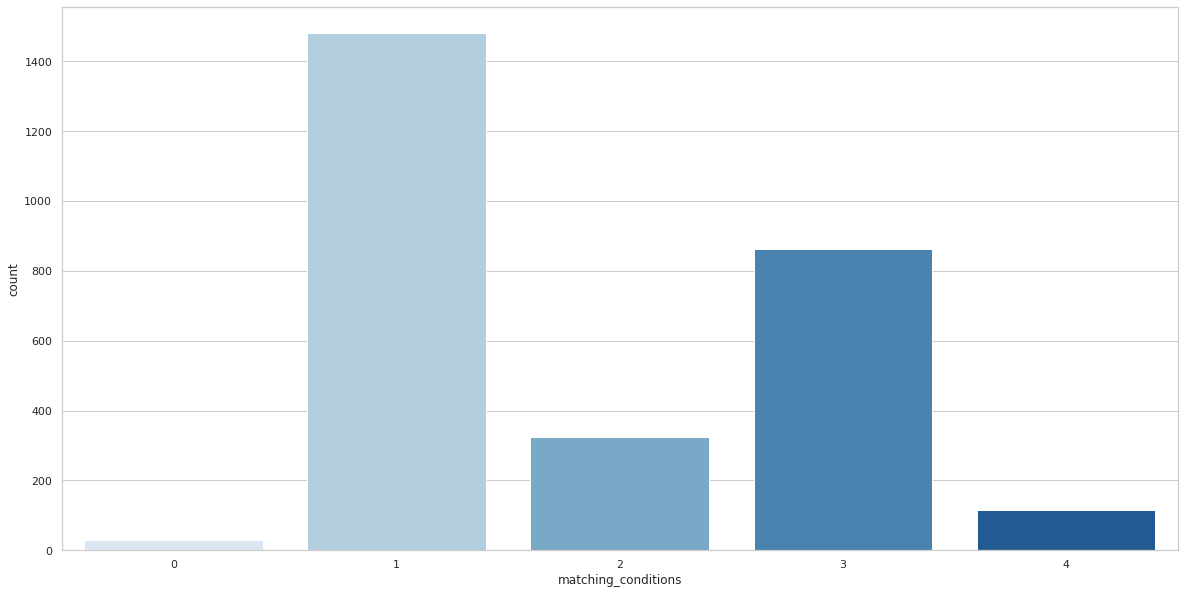

In [0]:
#plot distributions of trackers per visit_id
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(rc={'figure.figsize':(20,10)})
sns.set_style("whitegrid")

# Create an array with the colors you want to use
#colors = ["#FF0B04", "#4374B3"]
# Set your custom color palette
#sns.set_palette(sns.color_palette(colors))

sns.countplot(x="matching_conditions", data=script_url_df, palette="Blues")


## Analysis of Canvas Font Fingerprinting

In [0]:
#extracting set of individual script urls
script_url_set = list(set(js_canvas_df.script_url))

#prepare dataframe with individual script urls
canvas_font_df = pd.DataFrame(script_url_set, columns=['script_url'])
canvas_font_df.script_url = canvas_font_df.script_url.apply(lambda x: str(x))

canvas_font_df['font_setting'] = 0
canvas_font_df['font_setting_count'] = 0
canvas_font_df['measureText_calls'] = 0
canvas_font_df['measureText_calls_max_count'] = 0

canvas_font_df[:5]

,script_url,font_setting,font_setting_count,measureText_calls,measureText_calls_max_count
0,nan,0,0,0,0
1,https://www.wiwiweb.de/assets/js/wiwiweb_de-fu...,0,0,0,0
2,https://www.stromio.de/js/modernizr_2.8.3.min.js,0,0,0,0
3,https://www.rv-direkt.de/TSPD/086307da23ab2000...,0,0,0,0
4,https://cdn.asn.advolution.de/cr/00076d87/KYO_...,0,0,0,0


### Check Criteria for individual Scripts

Criteria:

1. The script sets CanvasRenderingContext2D.font property to at least 50 distinct, valid values.
2. The script calls the CanvasRenderingContext2D.measureText method at least 50 times on the same string.

#### (1) Font Setting

In [0]:
#extract CanvasRenderingContext2D.font elements
font_setting_df = js_canvas_df[js_canvas_df.symbol.isin(['CanvasRenderingContext2D.font'])]

#filter out elements with get operation (keep only set operations)
font_setting_df = font_setting_df[font_setting_df.operation.isin(["set"])]

#font_setting_df
len(font_setting_df)

4630

In [0]:
#check if scripts set 50 distinct fonts
#script_url = "https://m.stripe.network/inner.html#url=https%3A%2F%2Fslava.com.de%2F&title=Kochen%20%26%20Backen%20leicht%20gemacht%20mit%20Schritt%20f%C3%BCr%20Schritt%20Bildern%20von%20%26%20mit%20Slava&referrer=&muid=0a8ed844-dc0a-48d6-a255-cbc238e5fbb5&sid=c297908b-9afa-4a32-aeea-5aa8a388df67&preview=false"

for script_url in canvas_font_df.script_url:
    #select elements for current script url
    filtered_df = font_setting_df[font_setting_df.script_url == script_url]

    #check whether script contains font setting elements
    if len(filtered_df) == 0:
        canvas_font_df['font_setting'][canvas_font_df.script_url == script_url] = False
        canvas_font_df['font_setting_count'][canvas_font_df.script_url == script_url] = 0
        continue
    else:
        #count number of distinct font settings
        font_list = list(set(filtered_df.value))

        if len(font_list) >= 50:
            canvas_font_df['font_setting'][canvas_font_df.script_url == script_url] = True
            canvas_font_df['font_setting_count'][canvas_font_df.script_url == script_url] = len(font_list)
        else:
            canvas_font_df['font_setting'][canvas_font_df.script_url == script_url] = False
            canvas_font_df['font_setting_count'][canvas_font_df.script_url == script_url] = len(font_list)  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-pac

In [0]:
canvas_font_df
canvas_font_df[canvas_font_df.font_setting == True][:5]

,script_url,font_setting,font_setting_count,measureText_calls,measureText_calls_max_count
235,https://m.stripe.network/inner.html#url=https%...,True,60,0,0
368,https://m.stripe.network/inner.html#url=https%...,True,60,0,0
388,https://www.marriott.de/common/js/marriottComm...,True,87,0,0
451,https://go.lynxbroker.de/eat_session.js,True,205,0,0
455,https://m.stripe.network/inner.html#url=https%...,True,60,0,0


#### (2) measureText calls on same String

In [0]:
#extract CanvasRenderingContext2D.measureText elements
measureText_calls_df = js_canvas_df[js_canvas_df.symbol.isin(['CanvasRenderingContext2D.measureText'])]

#filter out elements with get operation (keep only set operations)
measureText_calls_df = measureText_calls_df[measureText_calls_df.operation.isin(["call"])]

#measureText_calls_df
len(measureText_calls_df)

2590

In [0]:
#script_url = "https://cdn1.f-cdn.com/fp/check.js;CIS3SID=B8F98ED5FF39E9B4CA3D67694816A9CB?org_id=lar9e74p&session_id=b1bc05b084917ee93d769642ce36cbced6a9af69abe0fbb6aa1cc0544d7eb6bd38024040fbfff70b&nonce=41173e096c160d94&jb=373124246a736d75354c616e77782662716f3f4e616c757a246a7160773f4469726766677824687b623f46697067646d782532323530"

for script_url in canvas_font_df.script_url:
    #select elements for current script url
    filtered_df = measureText_calls_df[measureText_calls_df.script_url == script_url]

    #check whether script contains font setting elements
    if len(filtered_df) == 0:
        canvas_font_df['measureText_calls'][canvas_font_df.script_url == script_url] = False
        canvas_font_df['measureText_calls_max_count'][canvas_font_df.script_url == script_url] = 0
        #continue
    else:
        #count number of measureText method calls for different strings in arguments
        args_value_counts = filtered_df.arguments.value_counts().rename_axis('string').reset_index(name='count')

        #check max number of method calls on the same string
        max_count = args_value_counts["count"].max()

        if max_count >= 50:
            canvas_font_df['measureText_calls'][canvas_font_df.script_url == script_url] = True
            canvas_font_df['measureText_calls_max_count'][canvas_font_df.script_url == script_url] = max_count
        else:
            canvas_font_df['measureText_calls'][canvas_font_df.script_url == script_url] = False
            canvas_font_df['measureText_calls_max_count'][canvas_font_df.script_url == script_url] = max_count


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarni

In [0]:
canvas_font_df
canvas_font_df[canvas_font_df.measureText_calls == True]
canvas_font_df[canvas_font_df.measureText_calls_max_count != 0][:5]

,script_url,font_setting,font_setting_count,measureText_calls,measureText_calls_max_count
68,https://www.verwoehnwochenende.de/assets/min/s...,False,20,False,40
235,https://m.stripe.network/inner.html#url=https%...,True,60,True,58
368,https://m.stripe.network/inner.html#url=https%...,True,60,True,58
388,https://www.marriott.de/common/js/marriottComm...,True,87,True,86
451,https://go.lynxbroker.de/eat_session.js,True,205,True,204


### Make Decision on Fingerprinting based on Results

In [0]:
#prepare result column
canvas_font_df['result'] = 0

#determine final result
for i in range(len(canvas_font_df)):

    if (canvas_font_df['font_setting'][i] == True) and (canvas_font_df['measureText_calls'][i] == True):
        canvas_font_df.result[i] = 2
    elif (canvas_font_df['font_setting'][i] == False) and (canvas_font_df['measureText_calls'][i] == False):
        canvas_font_df.result[i] = 0
    else:
        canvas_font_df.result[i] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [0]:
canvas_font_df[canvas_font_df.result != 0][:5]

,script_url,font_setting,font_setting_count,measureText_calls,measureText_calls_max_count,result
235,https://m.stripe.network/inner.html#url=https%...,True,60,True,58,2
368,https://m.stripe.network/inner.html#url=https%...,True,60,True,58,2
388,https://www.marriott.de/common/js/marriottComm...,True,87,True,86,2
451,https://go.lynxbroker.de/eat_session.js,True,205,True,204,2
455,https://m.stripe.network/inner.html#url=https%...,True,60,True,58,2


### Analyze Results of Canvas Font Fingerprinitng across Websites

In [0]:
#extract scripts that fulfill both conditions
canvas_font_fp_df = canvas_font_df[canvas_font_df.result == 2]

canvas_font_fp_scripts_list = list(canvas_font_fp_df.script_url)
canvas_font_fp_scripts_list
len(canvas_font_fp_scripts_list)

14

In [0]:
#extract visit ids for respective figerprinting scripts
font_fp_df = js_canvas_df[js_canvas_df.script_url.isin(canvas_font_fp_scripts_list)]
font_fp_df

,script_url,symbol,operation,value,top_level_url,func_name,arguments,visit_id
264790,https://m.stripe.network/inner.html#url=https%...,HTMLCanvasElement.getContext,call,NaN,https://slava.com.de/,StripeM<,"[""2d""]",699
264811,https://m.stripe.network/inner.html#url=https%...,CanvasRenderingContext2D.font,set,"72px monospace, monospace",https://slava.com.de/,v,NaN,699
264812,https://m.stripe.network/inner.html#url=https%...,CanvasRenderingContext2D.measureText,call,NaN,https://slava.com.de/,v,"[""mmmmmmmmmmlli""]",699
264813,https://m.stripe.network/inner.html#url=https%...,CanvasRenderingContext2D.font,set,"72px sans-serif, monospace",https://slava.com.de/,v,NaN,699
264814,https://m.stripe.network/inner.html#url=https%...,CanvasRenderingContext2D.measureText,call,NaN,https://slava.com.de/,v,"[""mmmmmmmmmmlli""]",699
...,...,...,...,...,...,...,...,...
1984060,https://m.stripe.network/inner.html#url=https%...,CanvasRenderingContext2D.measureText,call,NaN,https://der-kleine-akif.de/,v,"[""mmmmmmmmmmlli""]",9466
1984061,https://m.stripe.network/inner.html#url=https%...,CanvasRenderingContext2D.font,set,"72px Wingdings 3, monospace",https://der-kleine-akif.de/,v,NaN,9466
1984062,https://m.stripe.network/inner.html#url=https%...,CanvasRenderingContext2D.measureText,call,NaN,https://der-kleine-akif.de/,v,"[""mmmmmmmmmmlli""]",9466
1984063,https://m.stripe.network/inner.html#url=https%...,CanvasRenderingContext2D.font,set,"72px Wingdings, monospace",https://der-kleine-akif.de/,v,NaN,9466


In [0]:
#determine on how many websites canvas font fingerprinting behaviour was detected

#total number of websites
print("total number of websites:", len(list(set(font_fp_df.visit_id))))
print("percentage of websites:", len(list(set(font_fp_df.visit_id)))/9281)

total number of websites: 14
percentage of websites: 0.001508458140286607


In [0]:
#percentage of scripts where fingerprinting was detected
len(canvas_font_fp_scripts_list)/len(canvas_font_df)

0.004978662873399715

## Analysis fo WebRTC Fingerprinting

In [0]:
#RTCPeerConnection.createDataChannel
#RTCPeerConnection.createOffer
#RTCPeerConnection.onicecandidate

#extract calls of RTCPeerConnection interface
rtc_pc_df = javascript_df[javascript_df.symbol.str.contains('RTCPeerConnection')]
rtc_pc_df

,script_url,symbol,operation,value,top_level_url,func_name,arguments,visit_id
13114,https://static.adsafeprotected.com/sca.17.4.95.js,RTCPeerConnection.localDescription,get,NaN,https://t3n.de/,a93/a167<,NaN,28
13115,https://static.adsafeprotected.com/sca.17.4.95.js,RTCPeerConnection.remoteDescription,get,NaN,https://t3n.de/,a93/a167<,NaN,28
13116,https://static.adsafeprotected.com/sca.17.4.95.js,RTCPeerConnection.signalingState,get,stable,https://t3n.de/,a93/a167<,NaN,28
13117,https://static.adsafeprotected.com/sca.17.4.95.js,RTCPeerConnection.iceGatheringState,get,new,https://t3n.de/,a93/a167<,NaN,28
13122,https://static.adsafeprotected.com/sca.17.4.95.js,RTCPeerConnection.localDescription,get,NaN,https://t3n.de/,a93/a167<,NaN,28
...,...,...,...,...,...,...,...,...
2063495,https://static.adsafeprotected.com/sca.17.4.95.js,RTCPeerConnection.signalingState,get,stable,https://www.vagboard.de/,a93/a167<,NaN,9972
2063496,https://static.adsafeprotected.com/sca.17.4.95.js,RTCPeerConnection.iceGatheringState,get,new,https://www.vagboard.de/,a93/a167<,NaN,9972
2063497,https://static.adsafeprotected.com/sca.17.4.95.js,RTCPeerConnection.idpLoginUrl,get,NaN,https://www.vagboard.de/,a93/a167<,NaN,9972
2063498,https://static.adsafeprotected.com/sca.17.4.95.js,RTCPeerConnection.peerIdentity,get,{},https://www.vagboard.de/,a93/a167<,NaN,9972


In [0]:
#extracting set of individual script urls
script_url_set = list(set(rtc_pc_df.script_url))

#prepare dataframe with individual script urls
webrtc_df = pd.DataFrame(script_url_set, columns=['script_url'])
webrtc_df.script_url = webrtc_df.script_url.apply(lambda x: str(x))

webrtc_df['createDataChannel'] = 0
webrtc_df['createOffer'] = 0
webrtc_df['onicecandidate'] = 0

webrtc_df

,script_url,createDataChannel,createOffer,onicecandidate
0,nan,0,0,0
1,https://www.vr-bank-muldental.de/TSPD/086307da...,0,0,0
2,https://pixel.yabidos.com/flimpobj.js?cb=15757...,0,0,0
3,https://pixel.yabidos.com/flimpobj.js?cb=15757...,0,0,0
4,https://www.die-vrbank.de/TSPD/086307da23ab200...,0,0,0
...,...,...,...,...
58,https://www.vbbremennord.de/TSPD/086b9480eaab2...,0,0,0
59,https://www.vr-genobank.de/TSPD/086307da23ab20...,0,0,0
60,https://cdn1.f-cdn.com/fp/check.js;CIS3SID=B8F...,0,0,0
61,https://vr-dachau.de/TSPD/086307da23ab2000a1b5...,0,0,0


### Check Criteria for individual Scripts

In [0]:
#script_url = "https://static.adsafeprotected.com/sca.17.4.95.js"

for script_url in webrtc_df.script_url:

    #select elements for current script url
    filtered_df = rtc_pc_df[rtc_pc_df.script_url == script_url]

    #check whether script contains all three RTCPeerConnection methods

    #RTCPeerConnection.createDataChannel
    if filtered_df.symbol.str.contains("RTCPeerConnection.createDataChannel").any():
        webrtc_df.createDataChannel[webrtc_df.script_url == script_url] = True
    else:
        webrtc_df.createDataChannel[webrtc_df.script_url == script_url] = False

    #RTCPeerConnection.createDataChannel
    if filtered_df.symbol.str.contains("RTCPeerConnection.createOffer").any():
        webrtc_df.createOffer[webrtc_df.script_url == script_url] = True
    else:
        webrtc_df.createOffer[webrtc_df.script_url == script_url] = False

    #RTCPeerConnection.createDataChannel
    if filtered_df.symbol.str.contains("RTCPeerConnection.onicecandidate").any():
        webrtc_df.onicecandidate[webrtc_df.script_url == script_url] = True
    else:
        webrtc_df.onicecandidate[webrtc_df.script_url == script_url] = False

In [0]:
webrtc_df

,script_url,createDataChannel,createOffer,onicecandidate
0,nan,False,False,False
1,https://www.vr-bank-muldental.de/TSPD/086307da...,True,True,True
2,https://pixel.yabidos.com/flimpobj.js?cb=15757...,True,True,True
3,https://pixel.yabidos.com/flimpobj.js?cb=15757...,True,True,True
4,https://www.die-vrbank.de/TSPD/086307da23ab200...,True,True,True
...,...,...,...,...
58,https://www.vbbremennord.de/TSPD/086b9480eaab2...,True,True,True
59,https://www.vr-genobank.de/TSPD/086307da23ab20...,True,True,True
60,https://cdn1.f-cdn.com/fp/check.js;CIS3SID=B8F...,True,True,True
61,https://vr-dachau.de/TSPD/086307da23ab2000a1b5...,True,True,True


### Make Decision on Fingerprinting based on Results

In [0]:
#determine final result
webrtc_df['result'] = webrtc_df.createDataChannel + webrtc_df.createOffer + webrtc_df.onicecandidate
webrtc_df

,script_url,createDataChannel,createOffer,onicecandidate,result
0,nan,False,False,False,0
1,https://www.vr-bank-muldental.de/TSPD/086307da...,True,True,True,3
2,https://pixel.yabidos.com/flimpobj.js?cb=15757...,True,True,True,3
3,https://pixel.yabidos.com/flimpobj.js?cb=15757...,True,True,True,3
4,https://www.die-vrbank.de/TSPD/086307da23ab200...,True,True,True,3
...,...,...,...,...,...
58,https://www.vbbremennord.de/TSPD/086b9480eaab2...,True,True,True,3
59,https://www.vr-genobank.de/TSPD/086307da23ab20...,True,True,True,3
60,https://cdn1.f-cdn.com/fp/check.js;CIS3SID=B8F...,True,True,True,3
61,https://vr-dachau.de/TSPD/086307da23ab2000a1b5...,True,True,True,3


### Analyze Results of Canvas Font Fingerprinitng across Websites

In [0]:
#extract scripts that fulfill both conditions
webrtc_fp_df = webrtc_df[webrtc_df.result == 3]

webrtc_fp_scripts_list = list(webrtc_fp_df.script_url)
webrtc_fp_scripts_list
len(webrtc_fp_scripts_list)

56

In [0]:
#extract visit ids for respective figerprinting scripts
rtc_pc_fp_df = rtc_pc_df[rtc_pc_df.script_url.isin(webrtc_fp_scripts_list)]
rtc_pc_fp_df

,script_url,symbol,operation,value,top_level_url,func_name,arguments,visit_id
15023,https://pixel.yabidos.com/flimpobj.js?cb=15757...,RTCPeerConnection.createDataChannel,call,NaN,https://www.wg-gesucht.de/,getIntIP,"[""""]",39
15024,https://pixel.yabidos.com/flimpobj.js?cb=15757...,RTCPeerConnection.createOffer,call,NaN,https://www.wg-gesucht.de/,getIntIP,"[""FUNCTION"",""FUNCTION""]",39
15025,https://pixel.yabidos.com/flimpobj.js?cb=15757...,RTCPeerConnection.onicecandidate,set,FUNCTION,https://www.wg-gesucht.de/,getIntIP,NaN,39
15029,https://pixel.yabidos.com/flimpobj.js?cb=15757...,RTCPeerConnection.onicecandidate,set,FUNCTION,https://www.wg-gesucht.de/,getIntIP/pc.onicecandidate,NaN,39
23958,https://js.datadome.co/tags.js,RTCPeerConnection.createDataChannel,call,NaN,https://www.blablacar.de/,_0x556fc3<,"[""""]",59
...,...,...,...,...,...,...,...,...
2057210,https://fiduciagad.de/TSPD/086307da23ab2000e52...,RTCPeerConnection.createOffer,call,NaN,https://fiduciagad.de/,Ll</<,"[""FUNCTION"",""FUNCTION""]",9939
2057211,https://fiduciagad.de/TSPD/086307da23ab2000e52...,RTCPeerConnection.onicecandidate,set,FUNCTION,https://fiduciagad.de/,Ll</<,NaN,9939
2057559,https://volksbank-luebbecker-land.de/TSPD/086b...,RTCPeerConnection.createDataChannel,call,NaN,https://volksbank-luebbecker-land.de/,_s</<,"[""""]",9944
2057560,https://volksbank-luebbecker-land.de/TSPD/086b...,RTCPeerConnection.createOffer,call,NaN,https://volksbank-luebbecker-land.de/,_s</<,"[""FUNCTION"",""FUNCTION""]",9944


In [0]:
#determine on how many websites webrtc based fingerprinting behaviour was detected

#total number of websites
print("total number of websites:", len(list(set(rtc_pc_fp_df.visit_id))))
print("percentage of websites:", len(list(set(rtc_pc_fp_df.visit_id)))/9281)

total number of websites: 54
percentage of websites: 0.005818338541105484


In [0]:
#percentage of scripts where fingerprinting was detected
len(webrtc_fp_scripts_list)/len(webrtc_df)

0.8888888888888888